**There are two ways of constructing a software design: One way is to make it so simple that there are obviously no deficiencies, and the other way is to make it so complicated that there are no obvious deficiencies. The first method is far more difficult. **

Making the google drive accessible to our script

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


We need a way of getting the data into the models that we will train

In [0]:
import os

os.chdir('/content/drive/My Drive/open_ai/one-piece-character-recognition')

data_dir = 'data'

train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
  train_dir,
  target_size=(224, 224),
  batch_size=batch_size,
  class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
  valid_dir,
  target_size=(224, 224),
  batch_size=batch_size,
  class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
  test_dir,
  target_size=(224, 224),
  batch_size=batch_size,
  class_mode='categorical'
)

Found 222 images belonging to 5 classes.
Found 99 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [0]:
num_classes = len( train_generator.class_indices )

In [20]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add( layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)) )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Conv2D(64, (3, 3), activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Conv2D(128, (3, 3), activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Flatten() )
model.add( layers.Dense(512, activation='relu') )
model.add( layers.Dense(num_classes, activation='softmax') )

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 86528)             0         
__________

In [0]:
model.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer=optimizers.RMSprop(lr=1e-4))

In [41]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch=train_generator.n/batch_size,
  epochs=30,
  validation_data=valid_generator,
  validation_steps=valid_generator.n/batch_size
)

Epoch 1/30
7/6 [==============================] - 4s 605ms/step - loss: 1.1474 - acc: 0.8071 - val_loss: 1.8023 - val_acc: 0.4343
Epoch 2/30
7/6 [==============================] - 3s 466ms/step - loss: 0.0222 - acc: 1.0000 - val_loss: 1.6251 - val_acc: 0.5152
Epoch 3/30
7/6 [==============================] - 3s 426ms/step - loss: 0.0150 - acc: 1.0000 - val_loss: 1.8168 - val_acc: 0.4747
Epoch 4/30
7/6 [==============================] - 3s 422ms/step - loss: 0.0123 - acc: 1.0000 - val_loss: 1.7151 - val_acc: 0.5354
Epoch 5/30
7/6 [==============================] - 3s 408ms/step - loss: 0.0101 - acc: 1.0000 - val_loss: 2.0581 - val_acc: 0.4949
Epoch 6/30
7/6 [==============================] - 3s 407ms/step - loss: 0.0077 - acc: 1.0000 - val_loss: 1.9240 - val_acc: 0.4747
Epoch 7/30
7/6 [==============================] - 3s 415ms/step - loss: 0.0060 - acc: 1.0000 - val_loss: 2.2001 - val_acc: 0.5051
Epoch 8/30
7/6 [==============================] - 3s 428ms/step - loss: 0.0059 - acc: 1.00

In [0]:
models_dir = 'model'
os.mkdir(models_dir)

In [0]:
model_name = 'cnn-30_cycles-no_data_augmentation.h5'
model_path = os.path.join(models_dir, model_name)

model.save(model_path)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_and_acc_from_history(history, figpath):
  
  fig = plt.figure()
  ax1 = fig.add_subplot(121)
  ax2 = fig.add_subplot(122)
  
  epochs = range( len(history.history['acc']) )
  
  ax1.scatter(epochs, history.history['acc'], label='Training Accuracy')
  ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
  ax1.legend()
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  
  ax2.scatter(epochs, history.history['loss'], label='Training Loss')
  ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
  ax2.legend()
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  
  plt.show()
  
  fig.savefig(figpath)
  plt.close(fig)

In [0]:
results_dir = 'results'
os.mkdir(results_dir)

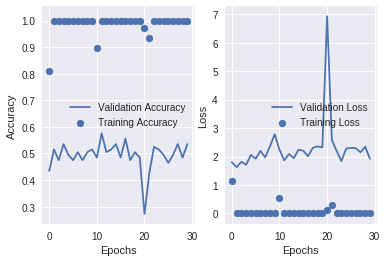

In [43]:
fname = 'cnn-30_cycles-no_data_augmentation.jpg'
fpath = os.path.join(results_dir, fname)

plot_loss_and_acc_from_history(history, fpath)

In [0]:
train_datagen = ImageDataGenerator(
  rotation_range=40,
  width_shift_range=0.2, 
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest'
)

In [63]:
from keras.preprocessing import image
import random

random_imagepath = random.choice(train_generator.filepaths)
img = image.load_img(random_imagepath, target_size=(224, 224))
plt.imshow(img)

img = image.img_to_array(img)
img = img.reshape( (1,) + img.shape )

i = 0
for batch in train_datagen.flow(img, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  if i == 20:
    break
  i += 1
  
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [68]:
train_generator = train_datagen.flow_from_directory(
  train_dir,
  target_size=(224, 224),
  batch_size=batch_size,
  class_mode='categorical'
)

Found 222 images belonging to 5 classes.


In [70]:
model = models.Sequential()
model.add( layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)) )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Conv2D(64, (3, 3), activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Conv2D(128, (3, 3), activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Conv2D(128, (3, 3), activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Flatten() )
model.add( layers.Dense(512, activation='relu') )
model.add( layers.Dense(num_classes, activation='softmax') )

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 128)       147584    
__________

In [0]:
model.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer=optimizers.RMSprop(lr=1e-5))

In [72]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch=200,
  epochs=100,
  validation_data=valid_generator,
  validation_steps=valid_generator.n//batch_size
)

Epoch 1/100
200/200 [==============================] - 132s 662ms/step - loss: 8.2577 - acc: 0.3082 - val_loss: 1.5914 - val_acc: 0.2239
Epoch 2/100
200/200 [==============================] - 132s 660ms/step - loss: 3.9130 - acc: 0.4290 - val_loss: 1.5982 - val_acc: 0.4627
Epoch 3/100
200/200 [==============================] - 132s 660ms/step - loss: 2.5449 - acc: 0.4788 - val_loss: 1.5997 - val_acc: 0.4179
Epoch 4/100
200/200 [==============================] - 132s 661ms/step - loss: 1.8382 - acc: 0.5324 - val_loss: 1.6004 - val_acc: 0.4583
Epoch 5/100
200/200 [==============================] - 132s 662ms/step - loss: 1.4301 - acc: 0.5902 - val_loss: 1.5986 - val_acc: 0.4478
Epoch 6/100
200/200 [==============================] - 133s 665ms/step - loss: 1.2022 - acc: 0.6221 - val_loss: 1.6029 - val_acc: 0.2985
Epoch 7/100
200/200 [==============================] - 134s 668ms/step - loss: 0.9971 - acc: 0.6736 - val_loss: 1.6000 - val_acc: 0.5224
Epoch 8/100
200/200 [====================

KeyboardInterrupt: ignored

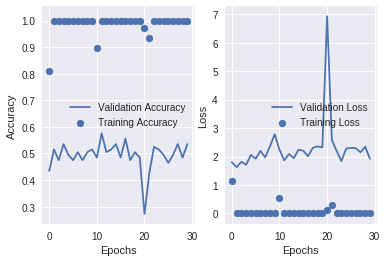

In [73]:
fname = 'cnn-30_cycles-data_augmentation.jpg'
fpath = os.path.join(results_dir, fname)

plot_loss_and_acc_from_history(history, fpath)

In [75]:
model = models.Sequential()
model.add( layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)) )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Conv2D(64, (3, 3), activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Conv2D(128, (3, 3), activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Dropout(0.3) )
model.add( layers.Conv2D(128, (3, 3), activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Dropout(0.3) )
model.add( layers.Flatten() )
model.add( layers.Dense(512, activation='relu') )
model.add( layers.Dropout(0.5) )
model.add( layers.Dense(num_classes, activation='softmax') )

print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 26, 26, 128)       0         
___________________________

In [0]:
model.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer=optimizers.RMSprop(lr=1e-5))

In [0]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch=200,
  epochs=100,
  validation_data=valid_generator,
  validation_steps=valid_generator.n//batch_size
)

Epoch 1/100
200/200 [==============================] - 135s 675ms/step - loss: 12.0344 - acc: 0.2431 - val_loss: 1.6396 - val_acc: 0.1979
Epoch 2/100
200/200 [==============================] - 134s 668ms/step - loss: 12.1975 - acc: 0.2430 - val_loss: 1.6646 - val_acc: 0.1791
Epoch 3/100
200/200 [==============================] - 134s 671ms/step - loss: 12.0144 - acc: 0.2436 - val_loss: 1.6315 - val_acc: 0.2239
Epoch 4/100
200/200 [==============================] - 135s 674ms/step - loss: 11.9342 - acc: 0.2474 - val_loss: 1.6275 - val_acc: 0.1791
Epoch 5/100
200/200 [==============================] - 134s 672ms/step - loss: 11.8965 - acc: 0.2498 - val_loss: 1.6151 - val_acc: 0.1875
Epoch 6/100
200/200 [==============================] - 134s 671ms/step - loss: 11.8735 - acc: 0.2452 - val_loss: 1.6285 - val_acc: 0.1940
Epoch 7/100
200/200 [==============================] - 134s 672ms/step - loss: 11.8783 - acc: 0.2398 - val_loss: 1.6143 - val_acc: 0.2388
Epoch 8/100
200/200 [=============

In [0]:
fname = 'cnn-30_cycles-data_augmentation-dropout.jpg'
fpath = os.path.join(results_dir, fname)

plot_loss_and_acc_from_history(history, fpath)